In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **IMPORT LIBRARIES** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Read Dataset

In [3]:
X_train = pd.read_csv("../input/titanic/train.csv")
X_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [4]:
X_test = pd.read_csv("../input/titanic/test.csv")
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


In [5]:
y_test = pd.read_csv("../input/titanic/gender_submission.csv")
y_test.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Train Values Analyze

In [6]:
X_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


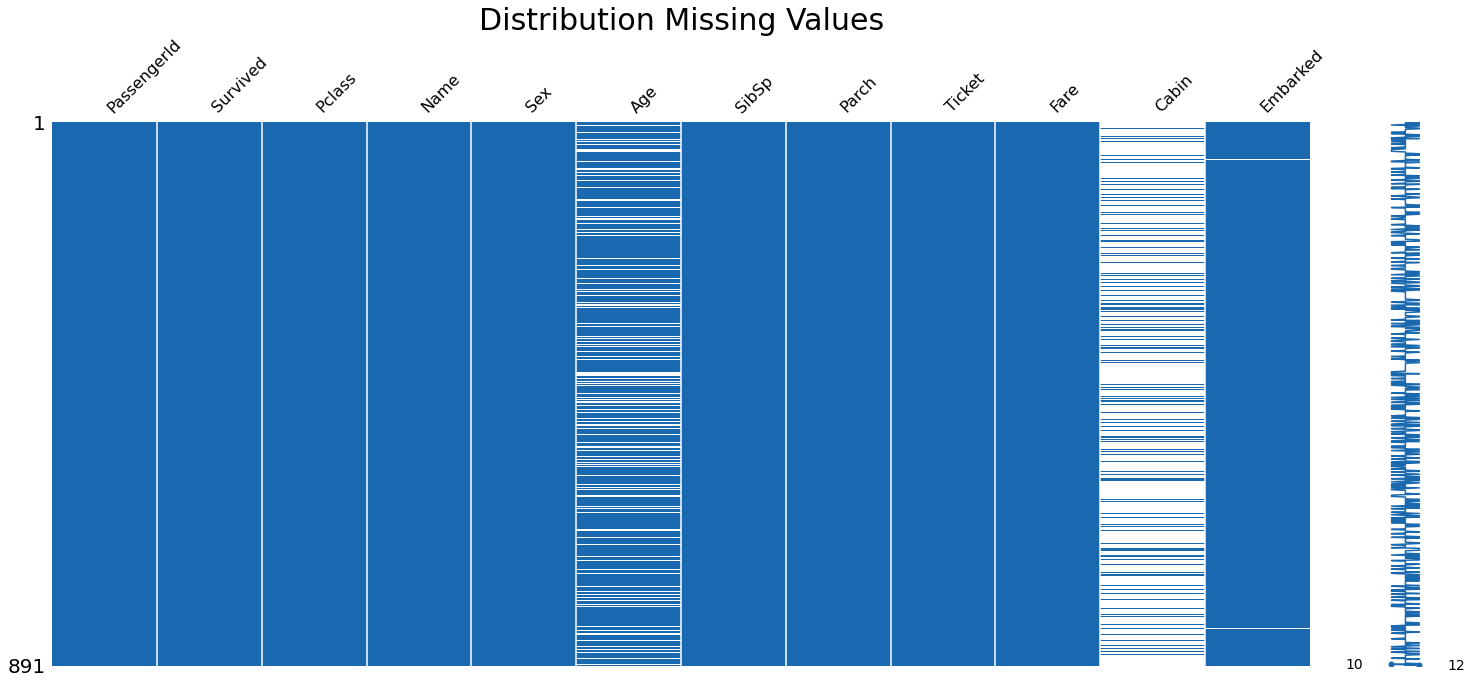

In [8]:
msno.matrix(X_train, color=(0.103, 0.410, 0.688))
plt.title('Distribution Missing Values',fontsize=30);

In [9]:
X_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

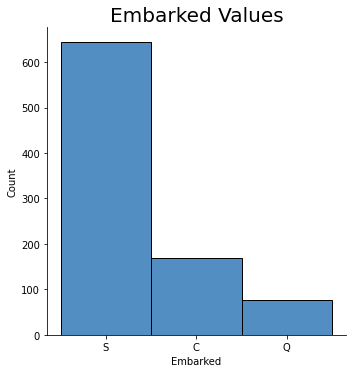

In [10]:
sns.displot(X_train['Embarked'],color=(0.103, 0.410, 0.688))
plt.title('Embarked Values', fontsize=20)
plt.show()

# Handling the Missing Values

In [11]:
# Deleting Cabin Data
X_train = X_train.drop(columns='Cabin', axis=1)

In [12]:
# Filling in Missing Values With the Mean Age
X_train['Age'].fillna(X_train['Age'].mean(), inplace=True)

In [13]:
#Filling in Missing Values With the Most Repeative Data
X_train["Embarked"] = X_train["Embarked"].fillna("S")

In [14]:
# Check for Missing Data
X_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

# Label Encoding

In [15]:
label_encoder = preprocessing.LabelEncoder()

X_train['Sex'] = label_encoder.fit_transform(X_train['Sex'])

X_train['Embarked'] = label_encoder.fit_transform(X_train['Embarked'])

X_train.drop(['Name', 'PassengerId', 'Ticket'], inplace=True, axis=1)

In [16]:
X_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000,1,0,7.250,2
1,1,1,0,38.000,1,0,71.283,0
2,1,3,0,26.000,0,0,7.925,2
3,1,1,0,35.000,1,0,53.100,2
4,0,3,1,35.000,0,0,8.050,2
5,0,3,1,29.699,0,0,8.458,1
6,0,1,1,54.000,0,0,51.862,2
7,0,3,1,2.000,3,1,21.075,2
8,1,3,0,27.000,0,2,11.133,2
9,1,2,0,14.000,1,0,30.071,0


# Test Values Analyze

In [17]:
X_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000,418.000,332.000,418.000,418.000,417.000
mean,1100.500,2.266,30.273,0.447,0.392,35.627
std,120.810,0.842,14.181,0.897,0.981,55.908
min,892.000,1.000,0.170,0.000,0.000,0.000
25%,996.250,1.000,21.000,0.000,0.000,7.896
50%,1100.500,3.000,27.000,0.000,0.000,14.454
75%,1204.750,3.000,39.000,1.000,0.000,31.500
max,1309.000,3.000,76.000,8.000,9.000,512.329


In [18]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [19]:
X_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# Handling the Missing Values (Test-Data)

In [20]:
# Deleting Cabin Data
X_test = X_test.drop(columns='Cabin', axis=1)

In [21]:
# Filling in Missing Values With the Mean Age
X_test['Age'].fillna(X_test['Age'].mean(), inplace=True)

In [22]:
# Filling in Missing Values With the Mean Fare
X_test["Fare"].fillna(X_test['Fare'].mean(), inplace=True)

In [23]:
# Check for Missing Data
X_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

# Label Encoding (Test-Data)

In [24]:
label_encoder = preprocessing.LabelEncoder()

X_test['Sex'] = label_encoder.fit_transform(X_test['Sex'])

X_test['Embarked'] = label_encoder.fit_transform(X_test['Embarked'])

X_test.drop(['Name', 'PassengerId', 'Ticket'], inplace=True, axis=1)

In [25]:
X_test.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.500,0,0,7.829,1
1,3,0,47.000,1,0,7.000,2
2,2,1,62.000,0,0,9.688,1
3,3,1,27.000,0,0,8.662,2
4,3,0,22.000,1,1,12.287,2
5,3,1,14.000,0,0,9.225,2
6,3,0,30.000,0,0,7.629,1
7,2,1,26.000,1,1,29.000,2
8,3,0,18.000,0,0,7.229,0
9,3,1,21.000,2,0,24.150,2


# Variable Describing

In [26]:
y = X_train["Survived"]
X = X_train.drop(["Survived"], axis=1)

# RANDOM FOREST

In [27]:
rf_model = RandomForestClassifier(random_state=17)

In [28]:
# Default Model
cv_results_rf = cross_validate(rf_model, X, y, cv=10, scoring=['accuracy', 'f1', 'roc_auc'])

In [29]:
cv_results_rf['test_accuracy'].mean()

0.8104244694132335

In [30]:
cv_results_rf['test_f1'].mean()

0.746087445183659

In [31]:
cv_results_rf['test_roc_auc'].mean()

0.8544071527600939

# Grid Search CV

In [32]:
# Default Parameters
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [35]:
# Parameters Defined for the Test
rf_params = {"max_depth": [5, 8, 10, 12],
             "max_features": [3, 5, 7, 9],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [90, 100, 110]}

In [ ]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=10, n_jobs=-1, verbose=True).fit(X, y)

In [37]:
#Training the Model
rf_final = rf_model.set_params(**rf_best_grid.best_params_).fit(X, y)

In [38]:
# Model Prepared with the Best Parameters
rf_final

RandomForestClassifier(max_depth=8, max_features=5, n_estimators=110,
                       random_state=17)

In [39]:
cv_results_rf = cross_validate(rf_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [40]:
cv_results_rf['test_accuracy'].mean()

0.83841566756638

In [41]:
cv_results_rf['test_f1'].mean()

0.7741566674273221

In [42]:
cv_results_rf['test_roc_auc'].mean()

0.8694576113797587

# Validation Curve Graphics

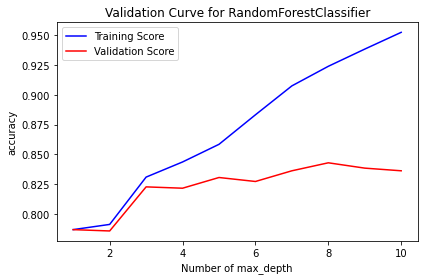

In [43]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='r')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

# Accuracy and Maximum Depth Curve
val_curve_params(rf_final, X, y, "max_depth", range(1, 11), scoring="accuracy")    

# Importance Graphics

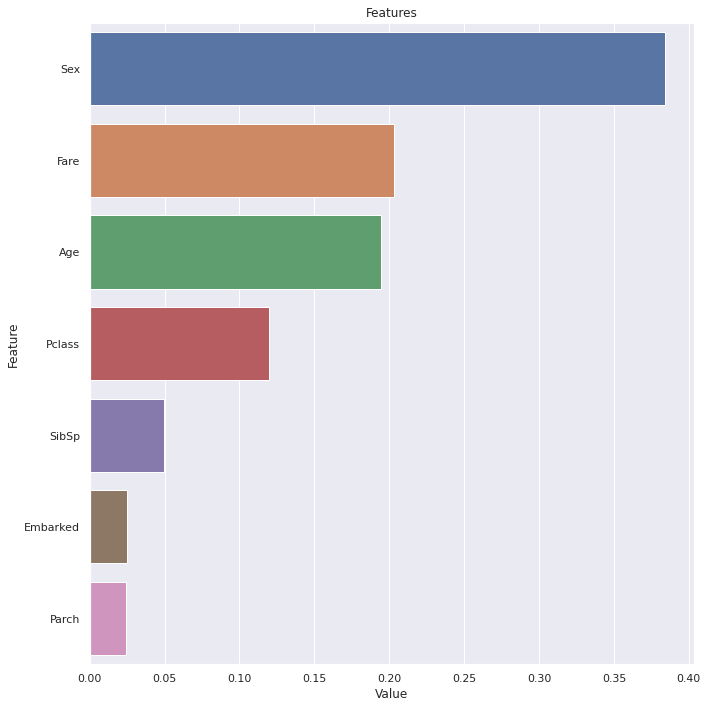

In [44]:
def plot_importance(model, features, num=len(X), save=True):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()

plot_importance(rf_final, X)

# PREDICTIONS

In [45]:
#Describing
y_test = y_test["Survived"]
y_pred = rf_final.predict(X_test)

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       266
           1       0.85      0.74      0.79       152

    accuracy                           0.86       418
   macro avg       0.86      0.83      0.84       418
weighted avg       0.86      0.86      0.86       418



# GRADIENT BOOSTING MACHINE

In [47]:
gbm_model = GradientBoostingClassifier(random_state=17)

In [48]:
# Default Parameters
gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [49]:
# Default Model
cv_results_gbm = cross_validate(gbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [50]:
cv_results_gbm['test_accuracy'].mean()

0.8215680120519743

In [51]:
cv_results_gbm['test_f1'].mean()

0.7480970940641442

In [52]:
cv_results_gbm['test_roc_auc'].mean()

0.8699869207573517

In [53]:
# Parameters Defined for the Test
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [7, 8, 10],
              "n_estimators": [180, 200, 240],
              "subsample": [0.4, 0.5, 0.7]}

In [54]:
#Finding the Best Parameters
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [55]:
#Training the Model
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)

In [56]:
# Model Prepared with the Best Parameters
gbm_final

GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=180,
                           random_state=17, subsample=0.5)

In [57]:
cv_results_gbm = cross_validate(gbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [58]:
cv_results_gbm['test_accuracy'].mean()

0.8417738999435063

In [59]:
cv_results_gbm['test_f1'].mean()

0.7746864246864248

In [60]:
cv_results_gbm['test_roc_auc'].mean()

0.8699155306318778

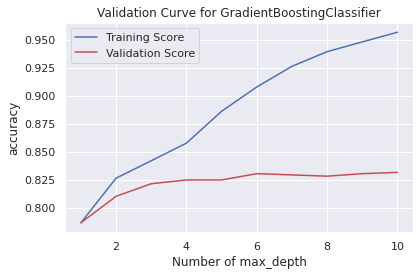

In [61]:
# Accuracy and Maximum Depth Curve
val_curve_params(gbm_final, X, y, "max_depth", range(1, 11), scoring="accuracy")   

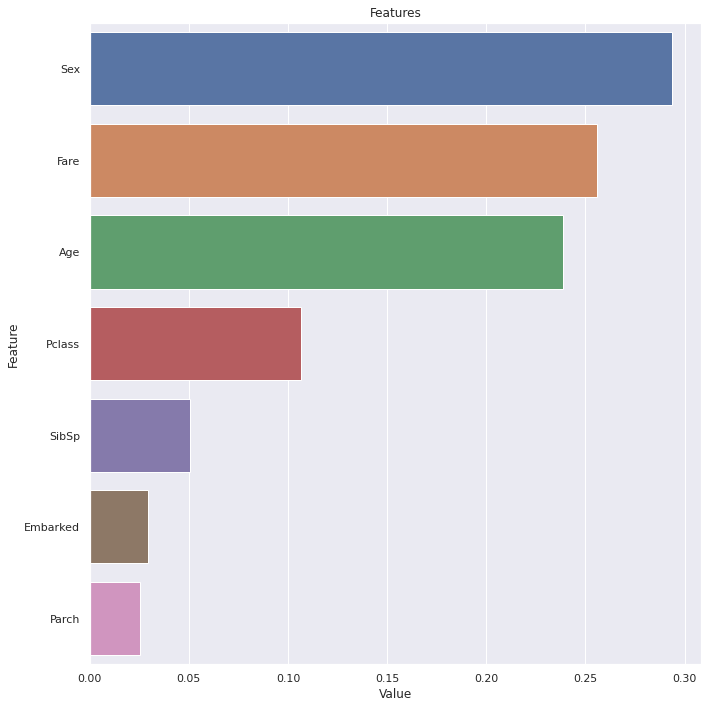

In [62]:
# Importance Graphics
plot_importance(gbm_final, X)

# PREDICTIONS

In [ ]:
y_test = y_test["Survived"]

In [64]:
y_pred = gbm_final.predict(X_test)

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       266
           1       0.86      0.73      0.79       152

    accuracy                           0.86       418
   macro avg       0.86      0.83      0.84       418
weighted avg       0.86      0.86      0.86       418



# EXTREME GRADIENT BOOSTING (XGBoost)

In [66]:
# Default Model
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)

In [67]:
cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [68]:
cv_results['test_accuracy'].mean()

0.8125980792166217

In [69]:
cv_results['test_f1'].mean()

0.7514361307477704

In [70]:
cv_results['test_roc_auc'].mean()

0.8575400002986291

In [71]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [4, 5, 7],
                  "n_estimators": [300, 500, 700],
                  "colsample_bytree": [0.7, 1, 1.2]}

In [ ]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

In [73]:
xgboost_best_grid.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 700}

In [74]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

In [75]:
cv_results = cross_validate(xgboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [76]:
cv_results['test_accuracy'].mean()

0.8372920720607621

In [77]:
cv_results['test_f1'].mean()

0.7725706928037437

In [78]:
cv_results['test_roc_auc'].mean()

0.8640999266225691

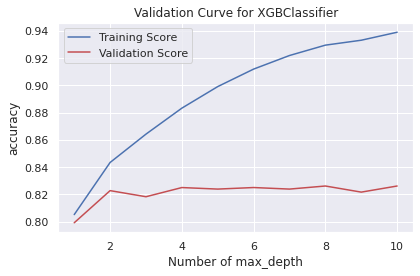

In [79]:
# Accuracy and Maximum Depth Curve
val_curve_params(xgboost_final, X, y, "max_depth", range(1, 11), scoring="accuracy")   

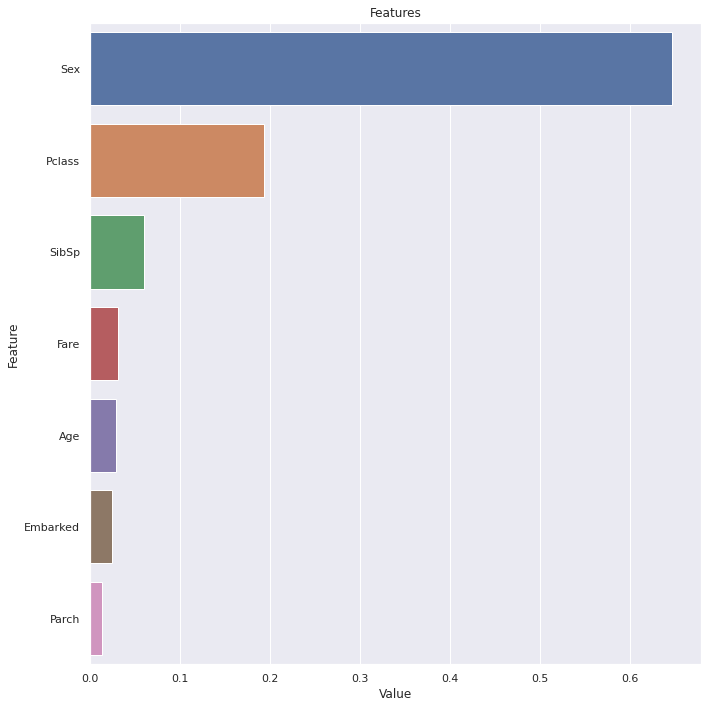

In [80]:
plot_importance(xgboost_final, X)

# PREDICTIONS

In [ ]:
y_test = y_test["Survived"]

In [82]:
y_pred = xgboost_final.predict(X_test)

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       266
           1       0.85      0.81      0.83       152

    accuracy                           0.88       418
   macro avg       0.87      0.87      0.87       418
weighted avg       0.88      0.88      0.88       418



# THANK YOU